In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
class DataCustom(Dataset):
    def __init__(self, csv_file, folder_root, transform=None):
        self.adnotari = pd.read_csv(csv_file)
        self.folder_root = folder_root
        self.transformare = transform

    def __len__(self):
        return len(self.adnotari)

    def __getitem__(self, id):
        img_path = f'{self.folder_root}/{self.adnotari.iloc[id, 0]}.png'
        image = Image.open(img_path).convert("RGB")
        eticheta = None
        if self.folder_root != 'Data/test':
            eticheta = int(self.adnotari.iloc[id, 1])
        if self.transformare:
            image = self.transformare(image)

        return image, eticheta


In [3]:
transformare = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[1, 1, 1]),
    # as putea face normalizare si doar scazand media imaginilro
])

In [4]:
csv_file = 'Data/train.csv'
data = pd.read_csv(csv_file)
folder_root = 'Data/train'
train_data = DataCustom(csv_file, folder_root, transformare)

csv_file = 'Data/validation.csv'
data = pd.read_csv(csv_file)
folder_root = 'Data/validation'
data_validare = DataCustom(csv_file, folder_root, transformare)

csv_file = 'Data/test.csv'
data = pd.read_csv(csv_file)
folder_root = ('Data/test')
test_data = DataCustom(csv_file, folder_root, transformare)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


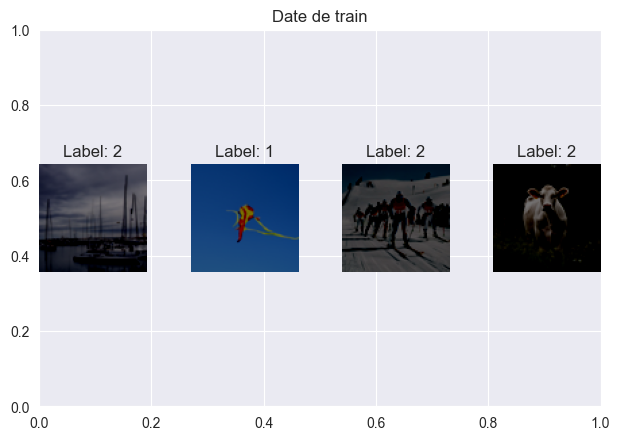

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


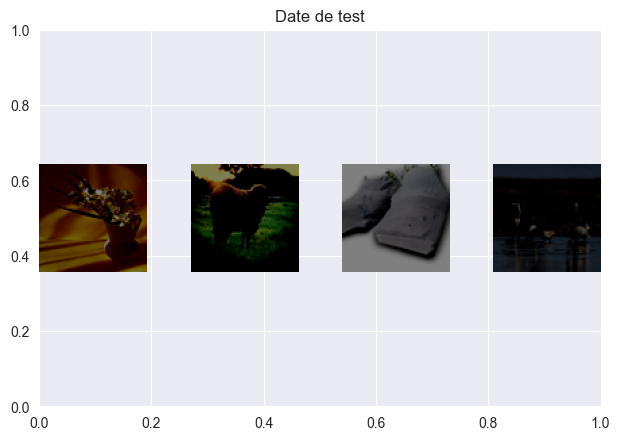

In [5]:
# plotam imaginile si deasupra lor scriem label-ul
fig = plt.figure()
plt.title("Date de train")
# plotam cateva imagini de antrenare
for i in range(len(train_data)):
    image, eticheta = train_data[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Label: %d' % eticheta)
    ax.axis('off')
    plt.imshow(image.permute(1, 2, 0))
    if i == 3:
        break
plt.show()
# plotam cateva imagini de test
fig = plt.figure()
plt.title("Date de test")
for i in range(len(test_data)):
    image = test_data[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')
    plt.imshow(image[0].permute(1, 2, 0))
    if i == 3:
        break
plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
class ReteaFF(nn.Module):
    def __init__(self):
        super(ReteaFF, self).__init__()
        self.sct1 = nn.Linear(3 * 80 * 80, 1024)
        self.sct2 = nn.Linear(1024, 2048)
        self.sct3 = nn.Linear(2048, 4096)
        self.sct4 = nn.Linear(4096, 8192)
        self.sct5 = nn.Linear(8192, 3)

    def forward(self, x):
        x = x.view(-1, 3 * 80 * 80)  # Flatten pentru intrare
        x = F.relu(self.sct1(x))
        x = F.relu(self.sct2(x))
        x = F.relu(self.sct3(x))
        x = F.relu(self.sct4(x))
        x = self.sct5(x)
        return x

# Testare model
rff = ReteaFF()
rff.to(device)

ReteaFF(
  (sct1): Linear(in_features=19200, out_features=1024, bias=True)
  (sct2): Linear(in_features=1024, out_features=2048, bias=True)
  (sct3): Linear(in_features=2048, out_features=4096, bias=True)
  (sct4): Linear(in_features=4096, out_features=8192, bias=True)
  (sct5): Linear(in_features=8192, out_features=3, bias=True)
)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rff.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rff.parameters(), lr=0.001)
evolutie_loss_validare = []
evolutie_loss_train = []
evolutie_precizie_train = []
evolutie_precizie_validare = []
epoci = 15
load_train = DataLoader(train_data, batch_size=32, shuffle=True)
load_validare = DataLoader(data_validare, batch_size=32, shuffle=False)

In [45]:
def validate():
    rff.eval()
    val_loss = 0.0
    corect = 0
    total = 0
    with torch.no_grad():
        for inputs, etichete in load_validare:
            inputs, etichete = inputs.to(device), etichete.to(device)
            outputs = rff(inputs)
            loss = criterion(outputs, etichete)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += etichete.size(0)
            corect += (predicted == etichete).sum().item()
    print(f'Pierdere validare: {val_loss / len(load_validare)}, Precizie validare: {corect / total}')
    evolutie_loss_validare.append(val_loss / len(load_validare))
    evolutie_precizie_validare.append(corect / total)


In [46]:
for epoca in range(epoci):
    rff.train()
    running_loss = 0.0
    corect = 0
    for inputs, eticheta in load_train:
        inputs, eticheta = inputs.to(device), eticheta.to(device)
        optimizer.zero_grad()
        outputs = rff(inputs)
        loss = criterion(outputs, eticheta)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        corect += (predicted == eticheta).sum().item()
    evolutie_loss_train.append(running_loss / len(load_train))
    evolutie_precizie_train.append(corect / len(load_train))
    validate()
    print(f"Epocă {epoca + 1}, Pierdere antrenament: {running_loss / len(load_train)}")

Epoca 1,
Pierdere antrenament: 1.093601205609852, acuratete: 0.41314285714285715
Pierdere validre: 1.0811427571672074, Precizie validare: 0.36666666666666664
-----------------------------------
Epoca 2,
Pierdere antrenament: 1.0849206155919013, acuratete: 0.430952380952381
Pierdere validre: 1.2361204966585686, Precizie validare: 0.381
-----------------------------------
Epoca 3,
Pierdere antrenament: 1.0689274436797052, acuratete: 0.4540952380952381
Pierdere validre: 1.0354678085509768, Precizie validare: 0.4836666666666667
-----------------------------------
Epoca 4,
Pierdere antrenament: 1.0315037094351007, acuratete: 0.4867619047619048
Pierdere validre: 1.073786291670292, Precizie validare: 0.4866666666666667
-----------------------------------
Epoca 5,
Pierdere antrenament: 1.0098180584269816, acuratete: 0.5112380952380953
Pierdere validre: 1.0193953767735908, Precizie validare: 0.5066666666666667
-----------------------------------
Epoca 6,
Pierdere antrenament: 0.9857289091794325

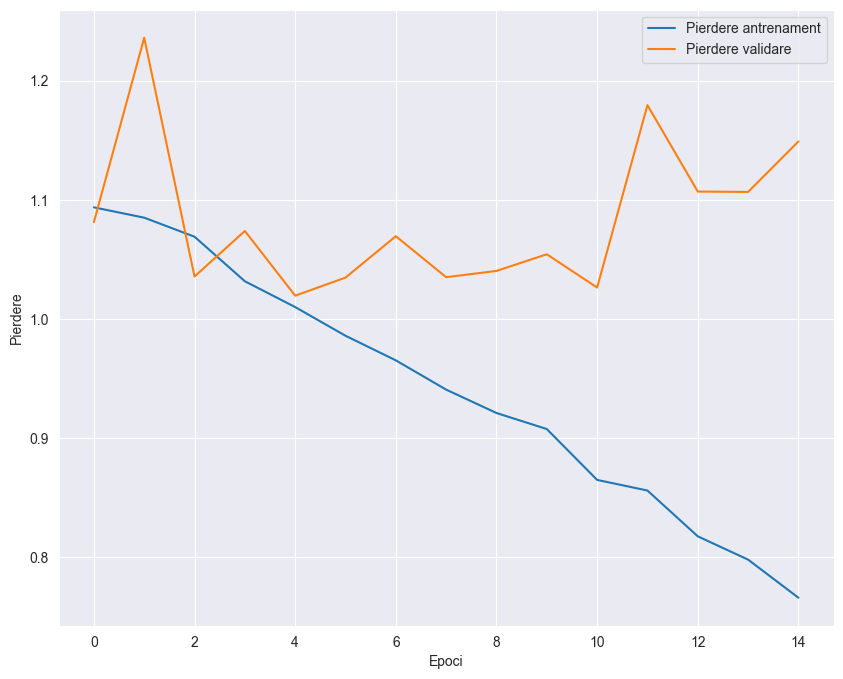

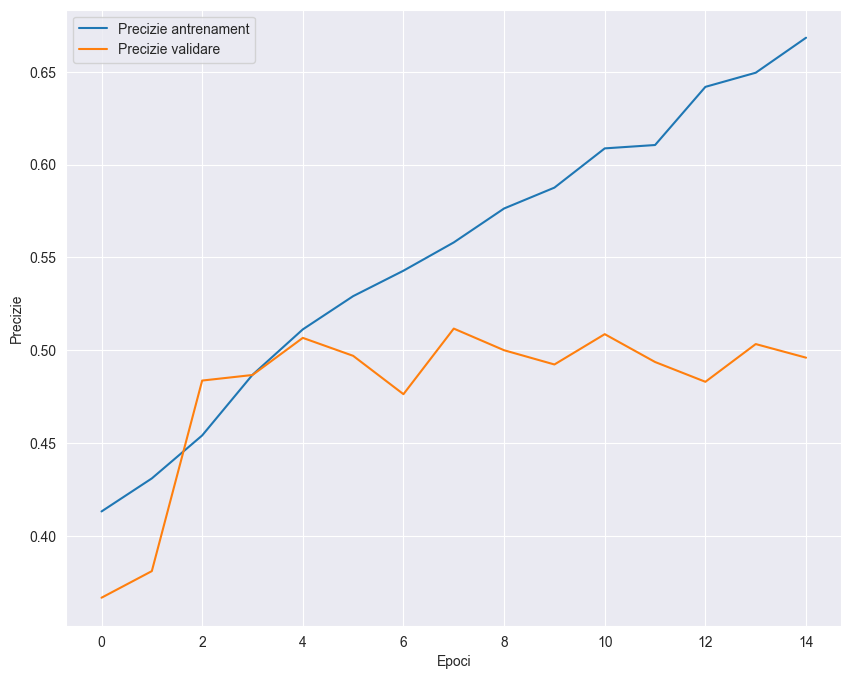

In [47]:
#plotam graficele
def matrice_de_confuzie(y_corect, y_prezis, classes):
    mc = confusion_matrix(y_corect, y_prezis)
    plt.figure(figsize=(10, 8))
    sns.heatmap(mc, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Eticheta adevarata')
    plt.xlabel('Eticheta prezisa')
    plt.show()


rff.eval()
y_corect = []
y_prezis = []
for input, eticheta in data_validare:
    output = rff(input)
    _, predictie = torch.max(output, 1)
    y_corect.extend(eticheta.tolist())
    y_prezis.extend(predictie.tolist())

matrice_de_confuzie(y_corect, y_prezis, ['0', '1', '2'])

# plotam evolutia pierderii si a preciziei
def plotare_grafice():
    plt.plot(evolutie_loss_train, label='Pierdere antrenament')
    plt.plot(evolutie_loss_validare, label='Pierdere validare')
    plt.xlabel('Epoci')
    plt.ylabel('Pierdere')
    plt.legend()
    plt.show()
    plt.plot(evolutie_precizie_validare, label='Precizie validare')
    plt.xlabel('Epoci')
    plt.ylabel('Precizie')
    plt.legend()
    plt.show()

plotare_grafice()
